# L-DED Audiovisual Fusion 

Author: Chen Lequn.
Created on 01 Feb 2023.

- Material： Maraging Steel 300
- Process: Robotic Llser-directed energy deposition
- Experiment number (single bead wall samples): 21-26
- Recorded data: position, veolocity, coaxial melt pool images, acoustic data
- Defect generated: keyhole pores, cracks, defect-free

### Notebook 4: Audiovisual fusion - baseline

- Testing on audio visual fusion with VGG-ish CNN model.

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.multiprocessing as mp

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

import os
import argparse
from torch.utils.data import Subset
import pandas as pd
import numpy as np

# Scikit learn
#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample, class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from vision_models import * 
from audiovisual_models import *
from multimodaldataset import MultimodalDataset, LDEDAudioDataset, LDEDVisionDataset
from utils import *
from train_utils import train_single_epoch, test_single_epoch, training_loop

from torchviz import make_dot

## plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
%matplotlib inline
import seaborn as sns

torch.manual_seed(0)

In [39]:
def get_sample_directories(base_path, sample_numbers):
    sample_directories = []
    for sample_number in sample_numbers:
        sample_directories.append(os.path.join(base_path, f'segmented_25Hz/{sample_number}'))
    return sample_directories

Multimodal_dataset_PATH = "/home/chenlequn/Dataset/LDED_acoustic_visual_monitoring_dataset"
samples = [21, 22, 23, 26]
sample_directories = get_sample_directories(Multimodal_dataset_PATH, samples)

# Get lists of image and audio directories for each sample
image_directories = [os.path.join(sample_dir, 'images') for sample_dir in sample_directories]
audio_directories = [os.path.join(sample_dir, 'equalized_audio') for sample_dir in sample_directories]

In [40]:
classes = ('Laser-off', 'Defect-free', 'Defective')
# classes = ('Laser-off', 'Defect-free', 'Cracks', "Keyhole pores")
SAMPLE_RATE = 44100
LEARNING_RATE = 0.00001
BATCH_SIZE = 32
EPOCHS = 10

### Utils functions

In [41]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'train_audio_visual')
os.makedirs(IMAGE_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

### Use GPU if possible

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")
# mp.set_start_method("spawn")
mp.set_start_method(method='forkserver', force=True)

Using cuda


### Annotation file

- Vision acoustic spatio-temporal registration has been done in our previous work. 
- Each frame (timestamp) corresponds to a robot TCP position.
- The duration for each frame is 0.01 seconds (sampling freqeuncy 10 Hz.)

In [43]:
# Combine all annotation files into one DataFrame
all_annotation_dfs = []
for sample_dir, sample_number in zip(sample_directories, samples):
    annotation_file = os.path.join(sample_dir, f'annotations_{sample_number}.csv')  # Update the file name
    annotation_df = pd.read_csv(annotation_file)
    all_annotation_dfs.append(annotation_df)
combined_annotation_df = pd.concat(all_annotation_dfs)

combined_annotation_df = combined_annotation_df.dropna(subset=['name'])
combined_annotation_df

sample index      audio_file_name      image_file_name         name  \
0                 1      sample_21_1.wav      sample_21_1.jpg    Laser-off   
1                 2      sample_21_2.wav      sample_21_2.jpg        Crack   
2                 3      sample_21_3.wav      sample_21_3.jpg        Crack   
3                 4      sample_21_4.wav      sample_21_4.jpg        Crack   
4                 5      sample_21_5.wav      sample_21_5.jpg  Defect-free   
...             ...                  ...                  ...          ...   
10981         10982  sample_26_10982.wav  sample_26_10982.jpg    Laser-off   
10982         10983  sample_26_10983.wav  sample_26_10983.jpg    Laser-off   
10983         10984  sample_26_10984.wav  sample_26_10984.jpg    Laser-off   
10984         10985  sample_26_10985.wav  sample_26_10985.jpg    Laser-off   
10985         10986  sample_26_10986.wav  sample_26_10986.jpg    Laser-off   

       class_ID class_name_v2  class_ID_2  Layer number  Sample number  \
0           0.0     Laser-off         0.0           1.0             21   
1           2.0     Defective         2.0           1.0             21   
2           2.0     Defective         2.0           1.0             21   
3           2.0     Defective         2.0           1.0             21   
4           1.0   Defect-free         1.0           1.0             21   
...         ...           ...         ...           ...            ...   
10981       0.0     Laser-off         0.0          50.0             26   
10982       0.0     Laser-off         0.0          50.0             26   
10983       0.0     Laser-off         0.0          50.0             26   
10984       0.0     Laser-off         0.0          50.0             26   
10985       0.0     Laser-off         0.0          50.0             26   

              X         Y          Z      name2  classification  class_ID_v2  
0      0.136620  0.265042   9.588183  Laser-off             0.0          NaN  
1      0.128219  0.275541   3.966295     Defect             2.0          NaN  
2      0.126358  0.276802   2.995122     Defect             2.0          NaN  
3      0.124890  0.278469   2.108443     Defect             2.0          NaN  
4      0.124157  0.278818   1.804407     Defect             2.0          NaN  
...         ...       ...        ...        ...             ...          ...  
10981  0.049866  0.333670  20.111111  Laser-off             0.0          NaN  
10982  0.049612  0.332770  19.226752  Laser-off             0.0          NaN  
10983  0.049823  0.333603  20.365324  Laser-off             0.0          NaN  
10984  0.049747  0.332576  18.765931  Laser-off             0.0          NaN  
10985  0.049826  0.333913  21.468823  Laser-off             0.0          NaN  

[27848 rows x 15 columns]

In [17]:
# Get the labels and count the number of samples for each class
labels = combined_annotation_df['class_name_v2'].values
label_counts = np.unique(labels, return_counts=True)[1]
print (label_counts)

[ 9056  6272 12520]


In [18]:
combined_annotation_df.iloc[1300,8]

21

### Basline accuracy
The baseline accuracy in this multi-class classificiation problem is **53%**, which is the accuracy of trivially predicting the most-frequent class (classify to the largest class– in other words).

In [19]:
### Get the percentage distribution of each category
round(combined_annotation_df.groupby('name')["name"].count()/combined_annotation_df.shape[0]*100, 1)

name
Crack             5.1
Defect-free      32.5
Keyhole pores    17.4
Laser-off        45.0
Name: name, dtype: float64

Saving figure dataset


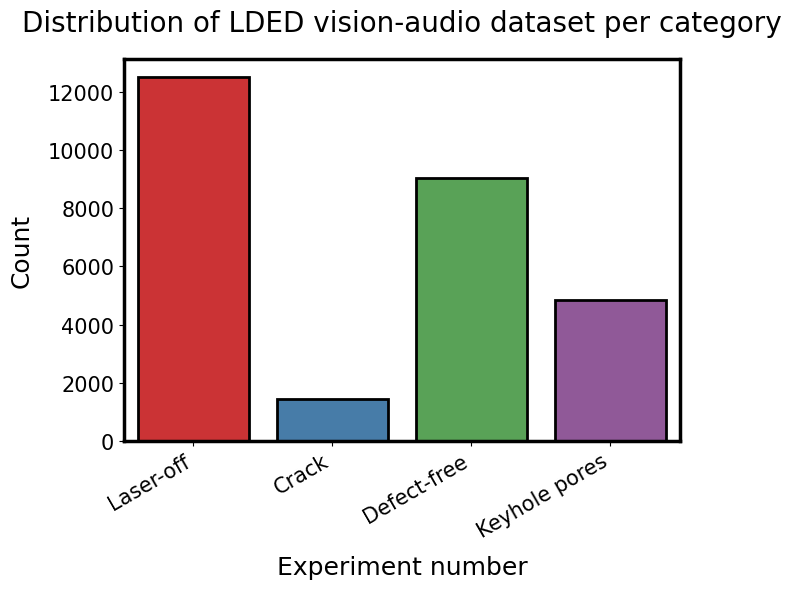

In [20]:
# sns.set(style="darkgrid")
plt.figure(figsize = (7,6))


ax = sns.countplot(x='name', data = combined_annotation_df, palette="Set1", linewidth=2,
                   edgecolor='k'); #palette='mako' 'Set2'
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
# ax = sns.countplot(y='label', data = df_dataset_denoised, palette="Set2");


ax.set_title('Distribution of LDED vision-audio dataset per category', fontsize = 20, pad=20);
ax.set_xlabel("Experiment number",fontsize=18, labelpad=10)
ax.set_ylabel("Count",fontsize=18, labelpad=10)
ax.tick_params(labelsize=15)

save_fig("dataset")

## Preparing Dataset and DataLoader

In [21]:
#------ transformation------
visual_train_transforms=transforms.Compose([
    torchvision.transforms.Resize((32,32)), # original image size: (640,480)
    transforms.RandomHorizontalFlip(),  # data augmentation
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
    transforms.ToTensor(),
    transforms.Normalize(mean=[63.66424300065244], std=[71.51866534828666]),
])

visual_val_transforms=transforms.Compose([
    torchvision.transforms.Resize((32,32)), # original image size: (640,480)
    transforms.ToTensor(),
    transforms.Normalize(mean=[63.66424300065244], std=[71.51866534828666]),
])

visual_test_transforms=transforms.Compose([
    torchvision.transforms.Resize((32,32)), # original image size: (640,480)
    transforms.ToTensor(),
    transforms.Normalize(mean=[63.66424300065244], std=[71.51866534828666]),
])

#------ audio transfomation------
# instantiating our dataset object and create data loader
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=512,
    hop_length=256,
    n_mels=32
)

MFCCs = torchaudio.transforms.MFCC(sample_rate=SAMPLE_RATE,n_mfcc=20)

/home/chenlequn/anaconda3/envs/torch/lib/python3.9/site-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [22]:
#------ data loader------
# create the dataset for all samples

mmd = MultimodalDataset(combined_annotation_df,
                            image_directories,
                            audio_directories,
                            samples,
                            visual_train_transforms,
                            mel_spectrogram,
                            SAMPLE_RATE,
                            device)

print ("length of the total dataset:" + str(len(mmd)))

length of the total dataset:27848


### Dealing with Imbalanced dataset: stratified sampling

- Split the data into train, validation, and test set
- Train and Val are used for hyperparameter tuning
- Train set will go through some data augmentation

In [23]:
# Split the data into train and validation datasets
# train_annotations, val_annotations = train_test_split(annotations_df, test_size=0.2)
# create the StratifiedShuffleSplit object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# split the indices of annotations into train and test sets
train_indices, test_indices = next(sss.split(combined_annotation_df, labels))

# split the data into train and test sets
train_annotations = combined_annotation_df.iloc[train_indices, :]
test_annotations = combined_annotation_df.iloc[test_indices, :]

# Create the train and validation datasets
train_dataset = MultimodalDataset(train_annotations,
                                  image_directories,
                                  audio_directories,
                                  samples,
                                  visual_train_transforms,
                                  mel_spectrogram,
                                  SAMPLE_RATE,
                                  device)

        
val_dataset = MultimodalDataset(test_annotations,
                                image_directories,
                                audio_directories,
                                samples,
                                visual_train_transforms,
                                mel_spectrogram,
                                SAMPLE_RATE,
                                device)

In [25]:
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# # split the indices of annotations into train, validation and test sets
# train_indices, test_val_indices = next(sss.split(annotations_df, labels))

# # Use another StratifiedShuffleSplit to split the test_val_indices into test and validation sets
# val_size = 0.5 # set the validation size
# sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=0)
# val_indices, test_indices = next(sss2.split(annotations_df.iloc[test_val_indices], labels[test_val_indices]))

# # split the data into train, validation, and test sets
# train_annotations = annotations_df.iloc[train_indices, :]
# val_annotations = annotations_df.iloc[val_indices, :]
# test_annotations = annotations_df.iloc[test_indices, :]

# # Create the train, validation and test datasets
# train_dataset = MultimodalDataset(train_annotations,
#                                   image_path = VISON_DIR,
#                                   audio_path = AUDIO_DIR,
#                                   image_transformation=visual_train_transforms,
#                                   MFCCs = MFCCs,
#                                   target_sample_rate = SAMPLE_RATE,
#                                   device=device)

# val_dataset = MultimodalDataset(val_annotations,
#                                 image_path = VISON_DIR,
#                                 audio_path = AUDIO_DIR,
#                                 image_transformation=visual_val_transforms,
#                                 MFCCs = MFCCs,
#                                 target_sample_rate = SAMPLE_RATE,
#                                 device=device)

# test_dataset = MultimodalDataset(test_annotations,
#                                  image_path = VISON_DIR,
#                                  audio_path = AUDIO_DIR,
#                                  image_transformation=visual_train_transforms,
#                                  MFCCs = MFCCs,
#                                  target_sample_rate = SAMPLE_RATE,
#                                  device=device)

### Create DataLoader using the dataset

In [26]:
# # Create train and val dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=6)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("length of the train dataset:" +  str(len(train_dataloader.dataset)))
print("length of the val dataset:" +  str(len(val_dataloader.dataset)))
# print("length of the test dataset:" +  str(len(test_dataloader.dataset)))

length of the train dataset:22278
length of the val dataset:5570


In [27]:
# model = AudioVisualFusionCNN().to(device)
# loss_fn = nn.CrossEntropyLoss()
# # Note: weight_decay in pytorch is L2 regularization
# # optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE,
# #                     momentum=0.9, weight_decay=5e-4)
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# for batch_idx, (inputs, targets) in enumerate(train_dataloader):
#     inputs = [x.to(device) for x in inputs]
#     targets = targets.to(device)
#     ## forward pass and calculate loss
#     outputs = model(*inputs)
#     # print (outputs)
#     print (targets)
#     # print(inputs[0].size(0))
#     # loss = loss_fn(outputs, targets)

## Training the model

In [28]:
resume = False
start_epoch = 0
best_acc = 0

In [29]:
# -----Model---------------
print('==> Building model..')

net = AudioVisualFusionCNN() 

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    print ("--- Using CUDA ---")

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

loss_fn = nn.CrossEntropyLoss()
# Note: weight_decay in pytorch is L2 regularization
# optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE,
#                     momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=5e-3) ## consider AdamW
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


model, optimizer, (train_losses, valid_losses, train_accuracy, valid_accuracy) = training_loop(net, loss_fn, optimizer,
                                                                                               train_dataloader, val_dataloader, EPOCHS, 
                                                                                               scheduler, device, mode = "multi_model")

==> Building model..
--- Using CUDA ---

Epoch: 0


Epoch 0:   0%|                 | 0/175 [00:20<?, ?it/s, loss=0.616, accuracy=94]


13:00:55 --- Epoch: 0	Train loss: 0.6796	Valid loss: 0.0193	Train accuracy: 88.37	Valid accuracy: 94.00

Epoch: 1


Epoch 1:   0%|                 | 0/175 [00:19<?, ?it/s, loss=0.636, accuracy=91]


13:01:56 --- Epoch: 1	Train loss: 0.6175	Valid loss: 0.0200	Train accuracy: 93.63	Valid accuracy: 90.99

Epoch: 2


Epoch 2:   0%|               | 0/175 [00:18<?, ?it/s, loss=0.605, accuracy=94.9]


13:02:56 --- Epoch: 2	Train loss: 0.6087	Valid loss: 0.0190	Train accuracy: 94.45	Valid accuracy: 94.92

Epoch: 3


Epoch 3:   0%|               | 0/175 [00:18<?, ?it/s, loss=0.606, accuracy=94.4]


13:03:57 --- Epoch: 3	Train loss: 0.6022	Valid loss: 0.0190	Train accuracy: 94.92	Valid accuracy: 94.43

Epoch: 4


Epoch 4:   0%|               | 0/175 [00:18<?, ?it/s, loss=0.617, accuracy=93.4]


13:04:57 --- Epoch: 4	Train loss: 0.6010	Valid loss: 0.0194	Train accuracy: 95.06	Valid accuracy: 93.38

Epoch: 5


Epoch 5:   0%|               | 0/175 [00:18<?, ?it/s, loss=0.597, accuracy=95.4]


13:05:56 --- Epoch: 5	Train loss: 0.5975	Valid loss: 0.0187	Train accuracy: 95.47	Valid accuracy: 95.44

Epoch: 6


Epoch 6:   0%|               | 0/175 [00:18<?, ?it/s, loss=0.588, accuracy=96.5]


13:06:55 --- Epoch: 6	Train loss: 0.5987	Valid loss: 0.0185	Train accuracy: 95.22	Valid accuracy: 96.46

Epoch: 7


Epoch 7:   0%|               | 0/175 [00:18<?, ?it/s, loss=0.662, accuracy=88.6]


13:07:55 --- Epoch: 7	Train loss: 0.5983	Valid loss: 0.0208	Train accuracy: 95.27	Valid accuracy: 88.56

Epoch: 8


Epoch 8:   0%|               | 0/175 [00:18<?, ?it/s, loss=0.599, accuracy=95.6]


13:08:55 --- Epoch: 8	Train loss: 0.5954	Valid loss: 0.0188	Train accuracy: 95.61	Valid accuracy: 95.62

Epoch: 9


Epoch 9:   0%|               | 0/175 [00:18<?, ?it/s, loss=0.592, accuracy=96.1]

13:09:54 --- Epoch: 9	Train loss: 0.5961	Valid loss: 0.0186	Train accuracy: 95.63	Valid accuracy: 96.07


In [30]:
valid_accuracy

[94.00359066427289,
 90.98743267504489,
 94.91921005385997,
 94.43447037701975,
 93.37522441651706,
 95.43985637342908,
 96.46319569120287,
 88.56373429084381,
 95.61938958707361,
 96.06822262118492]

Saving figure loss_accuracy_curve_multimodal


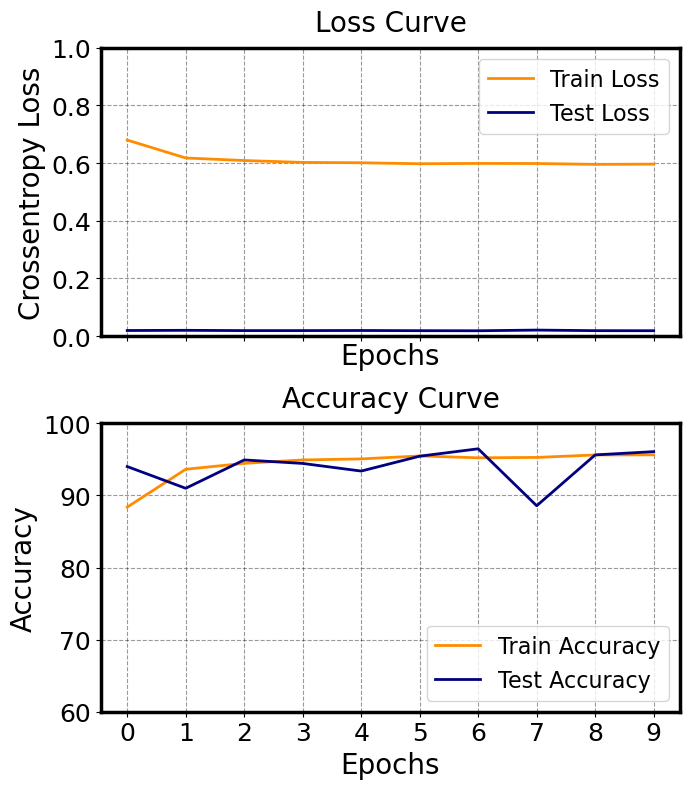

In [31]:
loss_acc_plot(train_losses, valid_losses, train_accuracy, valid_accuracy, 9, "Initial Training",
              interval=1, yloss_limit1=0, yloss_limit2=1.0, yacc_limit1=60, yacc_limit2=100)

save_fig ("loss_accuracy_curve_multimodal")

In [32]:
get_accuracy(model, val_dataloader, device, mode = 'multi_model')

0.9601436265709156

In [33]:
test_accuracy_mean, test_accuracy_std, auc_mean, auc_std = model_evaluation(model, val_dataloader, classes, device, classifier_name = "Hybrid-CNN",
                                                                            signal_type = "raw", seed=0, mode = 'multi_model')

save_fig ("ROC_curve (multimodal_fusion-based)")

Test Accuracy (cross-validation) for Hybrid-CNN = 0.96086 ± 0.00427
micro-averaging AUC for Hybrid-CNN = 0.99606 ± 0.00000
Saving figure ROC_curve (multimodal_fusion-based)


In [34]:
yt, yp = class_report(model, val_dataloader, device, classes, mode="multi_model")

              precision    recall  f1-score   support

 Defect-free     0.9537    0.9216    0.9374      1811
   Defective     0.8926    0.9402    0.9158      1255
   Laser-off     1.0000    0.9976    0.9988      2504

    accuracy                         0.9600      5570
   macro avg     0.9488    0.9531    0.9507      5570
weighted avg     0.9607    0.9600    0.9601      5570



[[1669  142    0]
 [  75 1180    0]
 [   6    0 2498]]
Saving figure confusion_matrix(audio_visual)


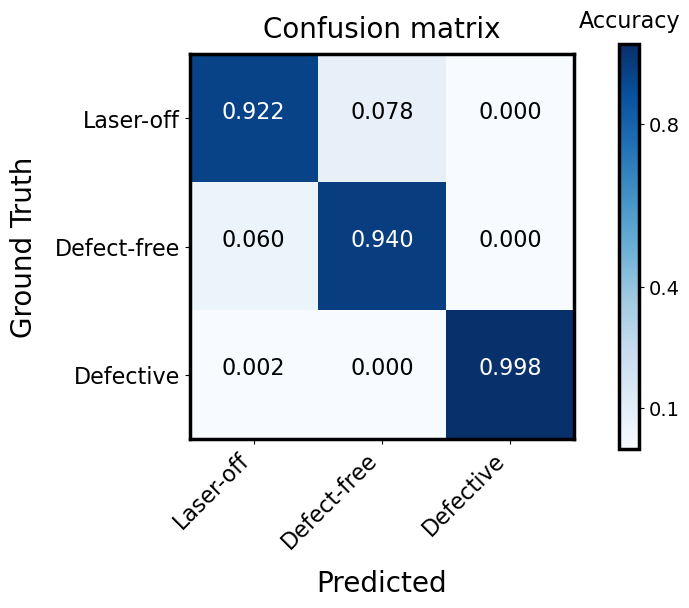

In [35]:
conf_matrix(yt, yp, classes)
save_fig("confusion_matrix(audio_visual)")

In [36]:
model = AudioVisualFusionCNN()
image = torch.randn(1, 1, 32, 32)
audio = torch.randn(1, 1, 32, 7)
predictions = model(image, audio)
# make_dot(predictions.mean(), params=dict(model.named_parameters()))
# make_dot(predictions)
# save_fig("multimodal_structure")
# make_dot(predictions.mean(), params=dict(model.named_parameters()),show_attrs=True, show_saved=True)